In [2]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

llm = genai.GenerativeModel(
    model_name='gemini-2.0-flash',
    )

c:\Users\LeeSeungYong\myproject\ai-agent\langgraph-tutorial\langgraph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
res = llm.generate_content('What is the capital of France? and tell me the population and population ratio of the capital')

In [4]:
from IPython.display import Image, display, Markdown
display(Markdown(res.text))

The capital of France is **Paris**.

Here's some information on Paris's population:

*   **Population (City of Paris, 2023 estimate):** Approximately 2.1 million

*   **Population (Greater Paris Metropolitan Area, 2023 estimate):** Approximately 12.3 million

*   **Population Ratio:** It's tricky to give a single "population ratio" without specifying what it's relative to.

    *   **Ratio of Paris to France:** The population of the city of Paris is roughly 3% of the total population of France (around 68 million). The population of the Greater Paris area is roughly 18% of the total population of France.

In [5]:
from pydantic import BaseModel, Field
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.environ["GOOGLE_API_KEY"],
    max_output_tokens=1000,
    temperature=1,
    max_retries=3,
    timeout=10,
    verbose=True,
    )

class SearchQuery(BaseModel):
    search_query : str = Field(
        None, 
        description = "Query that is optimized web search."
    )
    justification : str = Field(
        None, description="Why this query is relevant to the user's request."
    )

In [6]:
structured_llm = llm.with_structured_output(SearchQuery)

output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

def multiply(a:int, b:int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '78ab91e0-a41f-4b21-af73-23a8c278248b',
  'type': 'tool_call'}]

In [7]:
import json

json.dumps(
    output.model_dump_json(),
    indent=2,
    ensure_ascii=False
    )

'"{\\"search_query\\":\\"Calcium CT score and high cholesterol\\",\\"justification\\":\\"To find the relationship between Calcium CT score and high cholesterol.\\"}"'

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


workflow = StateGraph(State)

workflow.add_node('generate_joke', generate_joke)
workflow.add_node('improve_joke', improve_joke)
workflow.add_node('polish_joke', polish_joke)

workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {"Fail" : "improve_joke", "Pass" : END}
)
workflow.add_edge('improve_joke', 'polish_joke')
workflow.add_edge('polish_joke', END)

chain = workflow.compile()

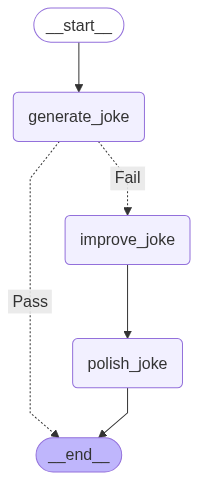

In [9]:
Image(chain.get_graph().draw_mermaid_png())

In [10]:
state = chain.invoke({
    'topic' : 'cats'
})

print('Initial Joke:')
print(state['joke'])
print('\n--- --- ---\n')
if "improved_joke" in state:
    print("Improved Joke:")
    print(state['improved_joke'])
    print('\n--- --- ---\n')

    print('Final Joke:')
    print(state['final_joke'])

else:
    print('Joke failed quality gate - no punchline detected!')

Initial Joke:
Why did the cat join the Red Cross?

Because it wanted to be a first aid kit! 

--- --- ---

Improved Joke:
Okay, here are a few options that add wordplay and try to make it funnier:

**Option 1 (Playing on "Claws"):**

> Why did the cat join the Red Cross?
>
> Because it wanted to use its *claws* to offer a *paw-some* first aid service! It heard they were feline good about helping people, and it wanted to get in on the act!

**Option 2 (Playing on "Purr-amedic"):**

> Why did the cat join the Red Cross?
>
> It wanted to become a *purr-amedic*! It was hoping to claw its way to the top of the medical field!

**Option 3 (A bit more absurd):**

> Why did the cat join the Red Cross?
>
> Because it was tired of just *kitten* around and wanted to make a *claw-some* contribution to emergency services!  It even promised not to *hiss*terically when things got tough!

**Option 4 (More pun-heavy):**

> Why did the cat join the Red Cross?
>
> It wanted to *paw-ticipate* in saving liv

In [11]:
state

{'topic': 'cats',
 'joke': 'Why did the cat join the Red Cross?\n\nBecause it wanted to be a first aid kit! ',
 'improved_joke': 'Okay, here are a few options that add wordplay and try to make it funnier:\n\n**Option 1 (Playing on "Claws"):**\n\n> Why did the cat join the Red Cross?\n>\n> Because it wanted to use its *claws* to offer a *paw-some* first aid service! It heard they were feline good about helping people, and it wanted to get in on the act!\n\n**Option 2 (Playing on "Purr-amedic"):**\n\n> Why did the cat join the Red Cross?\n>\n> It wanted to become a *purr-amedic*! It was hoping to claw its way to the top of the medical field!\n\n**Option 3 (A bit more absurd):**\n\n> Why did the cat join the Red Cross?\n>\n> Because it was tired of just *kitten* around and wanted to make a *claw-some* contribution to emergency services!  It even promised not to *hiss*terically when things got tough!\n\n**Option 4 (More pun-heavy):**\n\n> Why did the cat join the Red Cross?\n>\n> It wanted

## Parallelization

In [12]:
class State(TypedDict):
    topic : str
    joke : str 
    story : str 
    poem : str 
    combined_output : str

def call_llm_1(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"""Write a joke about {state['topic']}""")
    return {'joke' : msg.content}

def call_llm_2(state:State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {'story' : msg.content}

def call_llm_3(state:State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {'poem' : msg.content}


def aggregator(state:State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {'combined_output':combined}

In [13]:
parallel_builder = StateGraph(State)

parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, 'call_llm_1')
parallel_builder.add_edge(START, 'call_llm_2')
parallel_builder.add_edge(START, 'call_llm_3')

parallel_builder.add_edge('call_llm_1', "aggregator")
parallel_builder.add_edge('call_llm_2', "aggregator")
parallel_builder.add_edge('call_llm_3', "aggregator")
parallel_builder.add_edge('aggregator', END)

parallel_workflow = parallel_builder.compile()

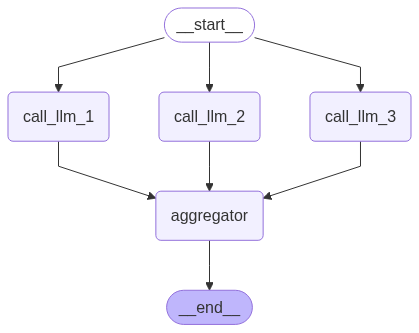

In [14]:
Image(parallel_workflow.get_graph().draw_mermaid_png())

In [15]:
state = parallel_workflow.invoke({'topic':'cats'})
print(state['combined_output'])

Here's a story, joke and poem about cats!

STORY:
The ginger tom, Marmalade, was the mayor of Sunbeam Alley. Not officially, of course. But everyone knew he ran things. From the prime napping spot on Mrs. Higgins' perpetually warm windowsill to the intricate network of garbage can tipping tactics, Marmalade was the mastermind.

He wasn't a bully, mind you. Just…organized. He ensured the black cat, Soot, got the first dibs on the fish scraps Mrs. Higgins always tossed out (Soot was getting old and his eyesight wasn't what it used to be). He personally escorted the shy calico, Patches, across the alley to visit her friend, Whiskers, a fluffy Persian who mostly just complained about her fur getting dirty.

Marmalade had a code. Protect the vulnerable. Respect the boundaries. And always, *always*, have a backup plan for a sudden downpour.

One day, a newcomer arrived. A sleek, silver cat with eyes like polished emeralds. He called himself Caspian, and he carried himself with an air of effo

## Orchestrator-Worker

In [16]:
from typing import Annotated, List
import operator
from langchain.schema import SystemMessage, HumanMessage


class Section(BaseModel):
    name : str = Field(description = 'Name for this sectioni of the report.')
    description : str = Field(description='Brief overview of the main topics and concepts to be covered in this section.')

class Sections(BaseModel):
    sections : List[Section] = Field(description = "Sections of the report.")

planner = llm.with_structured_output(Sections)

In [17]:
from langgraph.types import Send 

class State(TypedDict):
    topic : str 
    sections : list[Section]
    completed_sections : Annotated[list, operator.add]
    final_report : str

class WorkerState(TypedDict):
    section : Section
    completed_sections : Annotated[list, operator.add]

def orchestrator(state : State):
    """Orchestrator that generates a plan for the report"""
    report_sections = planner.invoke(
        [
            SystemMessage(content = 'Generate a plan for the report.'),
            HumanMessage(content = f"Here is the report topic : {state['topic']}")
        ]
    )
    return {'sections' : report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    section = llm.invoke(
        [
            SystemMessage(
                content = '''
                    Write a report section following the provided name 
                    and description. Include no preamble for each section. 
                    Use markdown formatting.
                    '''),
            HumanMessage(
                content = f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            )
        ]
    )
    return {"completed_sections" : [section.content]}
    
def synthesizer(state : State):
    """Synthesize full report from sections""" 

    completed_sections = state['completed_sections']
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {'final_report' : completed_report_sections}

def assign_workers(state : State):
    """Assign a worker to each section in the plan"""
    return [Send('llm_call', {"section" : s}) for s in state['sections']]

In [18]:
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node('orchestrator', orchestrator)
orchestrator_worker_builder.add_node('llm_call', llm_call)
orchestrator_worker_builder.add_node('synthesizer', synthesizer)
orchestrator_worker_builder.add_edge(START, 'orchestrator')
orchestrator_worker_builder.add_conditional_edges(
    'orchestrator', 
    assign_workers, 
    ['llm_call']
    )
orchestrator_worker_builder.add_edge('llm_call', 'synthesizer')
orchestrator_worker_builder.add_edge('synthesizer', END)

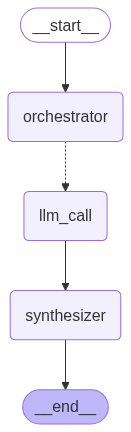

In [19]:
orchestrator_worker = orchestrator_worker_builder.compile()

Image(orchestrator_worker.get_graph().draw_mermaid_png())

In [20]:
state = orchestrator_worker.invoke(
    {'topic' : "Create a report on LLM scaling laws"}
)

In [21]:
from IPython.display import Markdown
Markdown(state['final_report'])

## Introduction to LLM Scaling Laws

Large Language Models (LLMs) have demonstrated remarkable capabilities in recent years, achieving state-of-the-art results in a wide range of natural language processing tasks. A key driver behind this progress is the observation of *scaling laws*, which describe the predictable relationship between model performance and factors like model size (number of parameters), dataset size (amount of training data), and compute budget (amount of computational resources used for training).

In essence, scaling laws suggest that as these factors increase, model performance generally improves in a predictable manner, often following a power-law relationship. This insight has profound implications for the design and training of future LLMs, enabling researchers and practitioners to:

*   **Predict performance:** Estimate the performance of a model given its size, dataset size, and compute budget before actually training it.
*   **Optimize resource allocation:** Determine the optimal combination of model size, dataset size, and compute to achieve desired performance levels, maximizing efficiency and minimizing costs.
*   **Guide model development:** Provide a roadmap for future research by indicating the potential benefits of scaling up model size and/or dataset size.

This report will explore the empirical evidence supporting LLM scaling laws, examine the mathematical formulations used to describe these relationships, discuss the theoretical underpinnings that explain why scaling laws hold, and address limitations and open questions surrounding their applicability and generalization. Understanding these laws is crucial for navigating the rapidly evolving landscape of LLMs and effectively leveraging their potential.

---

### Scaling Laws: Power Law Relationships

Power law relationships, frequently observed in large language models (LLMs), describe how model performance scales with key factors like model size (number of parameters), training dataset size, and computational budget. These relationships are often expressed as:

*   Performance ≈ A \* (Factor)^B

Where:

*   Performance is a measure of the model's ability (e.g., test loss, accuracy).
*   Factor is the scaling factor (e.g., number of parameters, dataset size, compute).
*   A is a constant factor.
*   B is the scaling exponent.

The exponent *B* is crucial. A value close to 1 implies near-linear scaling, while smaller values indicate diminishing returns. Identifying these exponents allows for:

*   **Predicting Performance:** Estimating performance gains from increasing model size or data without needing to train the larger model.
*   **Optimizing Resource Allocation:** Determining the most efficient allocation of compute and data to achieve desired performance levels.
*   **Understanding Model Behavior:** Insights into the underlying mechanisms driving model improvements with scale.

However, several caveats apply:

*   **Data Quality Matters:**  Scaling laws are often established on specific datasets. Performance may deviate significantly on different or poorly curated data.
*   **Architectural Dependence:**  The scaling exponents can vary depending on the model architecture (e.g., transformer, recurrent neural network).
*   **Plateaus and Breakdowns:** Power laws might not hold indefinitely. Saturation effects and unexpected behavior can occur at extreme scales.
*   **Fine-Tuning Impacts:** Scaling laws established during pre-training might not perfectly translate to performance after fine-tuning.

Research continues to refine our understanding of power law relationships and to develop more accurate and comprehensive models of LLM scaling. Understanding the limitations of these models is vital for responsible and efficient LLM development.

---

### Key Factors: Impact of Data, Compute, and Model Size

The performance of deep learning models is intrinsically linked to three key factors: the quantity and quality of the data used for training, the computational resources allocated for training, and the size and architecture of the model itself. Understanding the interplay between these factors is crucial for optimizing model performance and efficiency.

**Data:**

*   **Quantity:** Generally, larger datasets allow models to learn more robust and generalizable representations. More data helps to cover a wider range of variations and reduces the risk of overfitting to specific training examples. However, simply increasing the data volume may not always be beneficial if the data is noisy, biased, or irrelevant to the task.
*   **Quality:** High-quality data, characterized by accuracy, consistency, and completeness, is essential for effective model training. Data cleaning, preprocessing, and augmentation techniques can significantly improve model performance. Strategies such as removing duplicates, correcting errors, and addressing missing values are critical steps in ensuring data quality.
*   **Diversity:** A diverse dataset, encompassing a wide range of scenarios and edge cases, helps the model to generalize better to unseen data. This is especially important when deploying models in real-world environments where the data distribution may differ from the training distribution. Techniques like data augmentation can help improve the diversity of the training dataset.

**Compute:**

*   **Training Time:** Increased computational resources allow for faster training times, enabling more experimentation with different model architectures, hyperparameters, and training strategies. The use of GPUs or TPUs can significantly accelerate the training process, especially for large models and datasets.
*   **Model Complexity:** Higher computational power enables the training of more complex models with a larger number of parameters. Complex models can potentially capture more intricate patterns in the data, leading to improved accuracy.
*   **Hyperparameter Optimization:** Computational resources are essential for exploring the hyperparameter space efficiently. Techniques such as grid search, random search, and Bayesian optimization require substantial computational power to evaluate a large number of hyperparameter configurations.

**Model Size:**

*   **Capacity:** Larger models with more parameters have a greater capacity to learn complex relationships in the data. This can lead to improved performance, especially for tasks with high complexity.
*   **Overfitting:** While larger models can potentially achieve higher accuracy, they are also more prone to overfitting the training data. Regularization techniques, such as dropout, weight decay, and early stopping, are crucial for mitigating overfitting.
*   **Inference Cost:** Larger models typically require more computational resources for inference, leading to higher latency and increased deployment costs. Model compression techniques, such as pruning and quantization, can help reduce the model size and improve inference efficiency.
*   **Architecture:** The choice of model architecture plays a crucial role in determining performance. Different architectures are better suited for different tasks and data types. For example, Convolutional Neural Networks (CNNs) are well-suited for image recognition tasks, while Recurrent Neural Networks (RNNs) are commonly used for natural language processing. Transformer-based architectures have shown significant promise in a wide range of tasks, including natural language processing and computer vision.

In conclusion, achieving optimal model performance requires a careful balance between the size and quality of the data, the computational resources available, and the complexity and architecture of the model. Understanding the trade-offs between these factors is essential for developing effective and efficient deep learning solutions.

---

### Implications

*   **Enhanced Decision-Making:** More accurate and timely information about user behavior and system performance allows for data-driven decisions in areas like content recommendation, fraud detection, and resource allocation. This can lead to improved efficiency, reduced costs, and better user experiences.

*   **Personalized Experiences:** Granular insights into user preferences and usage patterns can be leveraged to create highly personalized experiences. This could involve tailoring content, recommending relevant products, or dynamically adjusting system parameters to optimize performance for individual users.

*   **Proactive Issue Identification:** By analyzing patterns and anomalies in the data, potential problems can be identified and addressed before they impact users. This proactive approach to problem-solving can minimize downtime, prevent service disruptions, and improve overall system reliability.

*   **Improved Security:** Identifying and responding to security threats in real-time becomes easier with access to detailed log data and user activity information. This can help to prevent data breaches, detect malicious activity, and protect sensitive information.

*   **Innovation and Development:** A deeper understanding of how users interact with the system can inspire new features, product improvements, and even entirely new business models. Data-driven insights can fuel innovation and keep the system competitive.

### Challenges

*   **Data Privacy and Security:** Handling sensitive user data requires robust security measures and adherence to strict privacy regulations (e.g., GDPR, CCPA). Data anonymization, encryption, and access controls are essential to protect user privacy and maintain trust.

*   **Data Volume and Scalability:** Processing and analyzing large volumes of data in real-time can be technically challenging and require significant computational resources. Scalable infrastructure and efficient data processing techniques are needed to handle the data deluge.

*   **Complexity and Integration:** Integrating diverse data sources and building a cohesive data pipeline can be complex and time-consuming. Ensuring data quality, consistency, and compatibility across different systems is crucial for accurate analysis.

*   **Interpretability and Actionability:** Deriving actionable insights from complex data requires specialized skills in data analysis and visualization. Communicating these insights effectively to stakeholders and translating them into concrete actions can be a challenge.

*   **Bias and Fairness:** Data used for decision-making may contain biases that can lead to unfair or discriminatory outcomes. Careful attention must be paid to identifying and mitigating biases in the data and algorithms to ensure fairness and equity.

*   **Resource Requirements:** Implementing and maintaining a system for detailed data collection, processing, and analysis requires significant investment in infrastructure, software, and personnel. Justifying these costs and demonstrating the return on investment can be challenging.

*   **Ethical Considerations:** The use of data to track and profile users raises ethical concerns about privacy, autonomy, and manipulation. Careful consideration must be given to the ethical implications of data usage and responsible data practices must be adopted.

---

### Future Trends

This section outlines potential future directions and promising avenues for research in the field.

*   **Explainable AI (XAI) Integration:**  Future research should focus on integrating XAI techniques to improve the transparency and interpretability of complex models. This is crucial for building trust and understanding the decision-making processes, especially in high-stakes applications.

*   **Multimodal Learning and Data Fusion:** Explore leveraging multimodal data (e.g., text, images, audio) for enhanced feature extraction and model performance.  Research should focus on developing robust fusion techniques that can effectively combine information from diverse data sources.

*   **Federated Learning:** Investigate the application of federated learning to enable collaborative model training across distributed datasets while preserving data privacy. This is particularly relevant for scenarios where data sharing is restricted.

*   **Adversarial Robustness:**  Further research is needed to develop more robust models that are resilient to adversarial attacks and data perturbations. This includes exploring novel defense mechanisms and developing better metrics for evaluating model robustness.

*   **Domain Adaptation and Transfer Learning:** Explore techniques for effectively adapting models trained on one domain to perform well in another. This reduces the need for extensive retraining and allows for the reuse of existing knowledge.

*   **Automated Machine Learning (AutoML):**  Investigate the use of AutoML tools to streamline the model development process, making it more accessible to non-experts. Research should focus on improving the efficiency and effectiveness of AutoML algorithms.

*   **Ethical Considerations and Bias Mitigation:**  Future work must address the ethical implications of models and develop methods for mitigating bias in training data and model predictions. This includes promoting fairness, accountability, and transparency in algorithmic decision-making.

*   **Energy-Efficient Model Development:**  Focus on developing more energy-efficient models and training techniques to reduce the environmental impact of training and deploying large-scale models.  This includes exploring hardware-aware optimization strategies.

*   **Integration with Edge Computing:**  Research should explore strategies for deploying and running models on edge devices, enabling real-time processing and reduced latency. This is particularly relevant for applications such as autonomous vehicles and IoT devices.

In [22]:
state

{'topic': 'Create a report on LLM scaling laws',
 'sections': [Section(name='Introduction', description='Introduction to LLM Scaling Laws'),
  Section(name='Scaling Laws', description='Power Law Relationships'),
  Section(name='Key Factors', description='Impact of Data, Compute, and Model Size'),
  Section(name='Implications', description='Practical Implications and Challenges'),
  Section(name='Future Trends', description='Future Directions and Research')],
 'completed_sections': ['## Introduction to LLM Scaling Laws\n\nLarge Language Models (LLMs) have demonstrated remarkable capabilities in recent years, achieving state-of-the-art results in a wide range of natural language processing tasks. A key driver behind this progress is the observation of *scaling laws*, which describe the predictable relationship between model performance and factors like model size (number of parameters), dataset size (amount of training data), and compute budget (amount of computational resources used for

In [23]:
state['sections']

[Section(name='Introduction', description='Introduction to LLM Scaling Laws'),
 Section(name='Scaling Laws', description='Power Law Relationships'),
 Section(name='Key Factors', description='Impact of Data, Compute, and Model Size'),
 Section(name='Implications', description='Practical Implications and Challenges'),
 Section(name='Future Trends', description='Future Directions and Research')]

## Evaluator-optimizer

In [27]:
from typing import Literal

# Graph State
class State(TypedDict):
    joke : str
    topic : str 
    feedback : str 
    funny_or_not : str

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade : Literal["funny", "not funny"] = Field(
        description = "Decide if the joke is funny or not."
    )
    feedback : str = Field(
        description = "If the joke is not funny, provide feedback on how to improve it."
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [28]:
def llm_call_generator(state : State):
    """LLM generates a joke""" 
    if state.get('feedback'):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    
    return {'joke' : msg.content}

def llm_call_evaluator(state : State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not" : grade.grade, "feedback" : grade.feedback}

def route_joke(state : State):
    """Route back to joke generator or end based upon feedback from the evaluator""" 

    if state['funny_or_not'] == "funny":
        return "Accepted"
    elif state['funny_or_not'] == 'not funny':
        return "Rejected + Feedback"

In [29]:
optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

optimizer_builder.add_edge(START, 'llm_call_generator')
optimizer_builder.add_edge('llm_call_generator', 'llm_call_evaluator')
optimizer_builder.add_conditional_edges(
    'llm_call_evaluator',
    route_joke,
    {
        'Accepted' : END,
        'Rejected + Feedback' : 'llm_call_generator'
    }
)

optimizer_workflow = optimizer_builder.compile()

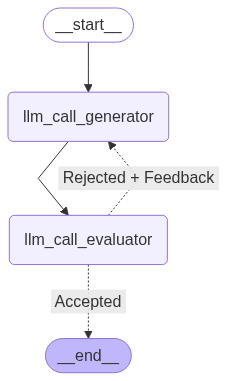

In [30]:
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [31]:
state = optimizer_workflow.invoke(
    {'topic' : "Cats"}
)

In [33]:
state
print(state['joke'])

Why don't cats play poker in the jungle?

Too many cheetahs!


## Agents

In [57]:
from langchain_core.tools import tool 

@tool 
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a : first int
        b : second int
    """
    return a * b 

@tool
def add(a : int, b : int) -> int:
    """Adds a and b. 

    Args:
        a: first int
        b: second int 
    """ 
    return a + b 

@tool
def divide(a : int, b : int) -> float: 
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name : tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [58]:
tools_by_name

{'add': StructuredTool(name='add', description='Adds a and b. \n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000021161F35C60>),
 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a : first int\n        b : second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000021161F35300>),
 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000021161F34AE0>)}

In [59]:
from langgraph.graph import MessagesState 
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage 

def llm_call(state : MessagesState):
    """LLM decides whether to call a tool or not"""
    return {
        "messages" : [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content = "You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state['messages']
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call""" 

    result = []
    for tool_call in state['messages'][-1].tool_calls:
        tool = tools_by_name[tool_call['name']]
        observation = tool.invoke(tool_call['args'])
        result.append(ToolMessage(content = observation, tool_call_id = tool_call['id']))

    return {'messages' : result}

def should_continue(state: MessagesState) -> Literal['environment', END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call""" 

    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        return "Action"
    return END

In [60]:
agent_builder = StateGraph(MessagesState)

agent_builder.add_node('llm_call', llm_call)
agent_builder.add_node('environment', tool_node)

agent_builder.add_edge(START, 'llm_call')
agent_builder.add_conditional_edges(
    'llm_call',
    should_continue,
    {
        "Action" : 'environment',
        END : END
    }
)
agent_builder.add_edge("environment", "llm_call")

agent = agent_builder.compile()

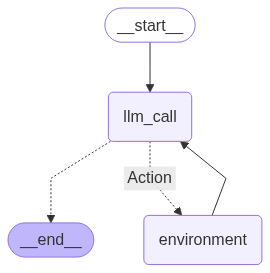

In [61]:
Image(agent.get_graph(xray=True).draw_mermaid_png())

In [62]:
messages = [HumanMessage(content = "Add 3 and 6.")]
messages = agent.invoke({
    "messages" : messages
})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 6.
================================== Ai Message ==================================
Tool Calls:
  add (b1e0fcea-10f3-40bb-afb0-f12b31fdfca3)
 Call ID: b1e0fcea-10f3-40bb-afb0-f12b31fdfca3
  Args:
    a: 3.0
    b: 6.0
================================= Tool Message =================================

9
================================== Ai Message ==================================

The sum of 3 and 6 is 9.


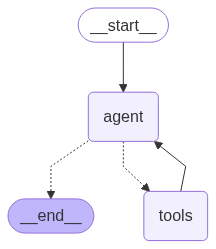

In [66]:
from langgraph.prebuilt import create_react_agent 

pre_built_agent = create_react_agent(llm, tools = tools)

display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

In [67]:
messages = [HumanMessage(content = 'Add 3 and 5.')]
messages = pre_built_agent.invoke(
    {'messages' : messages}
)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 5.
================================== Ai Message ==================================
Tool Calls:
  add (4455578f-cd88-4f7c-b01b-5fdaec26c379)
 Call ID: 4455578f-cd88-4f7c-b01b-5fdaec26c379
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================

3 + 5 = 8
